# New Plant Disease - Classification using Tensorflow 2.x

## 1. Environment preparation
1. Make sure TensorFlow is installed 
2. Check if we are connected to GPU



In [1]:
# Import TensorFlow into collab
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.0


### Use GPU

For the purpose of Image Classification, we will use GPU to allow us to use Kaggle resources. This will help us to considerably improve the capacity of the laptop to execute ML programs.

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 2. Initialisation code 

In [3]:
# Import required packages
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Get Path to Train and Valid folders
train_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# Get list of all subfolders for each Subset
train_dir = os.listdir(train_path)
valid_dir = os.listdir(valid_path)
# Check length of subfolders
len(train_dir), len(valid_dir)

(38, 38)

We will create DataFrame to stor required information for our program.
DataFrames are the same used during **Data Vizualisation** report.

Train and Validation Dataframe composed of:
- List of Plants name (Plant)
- List of Plants Categories (Category)
- List of images path (Path) > Features
- List of Plants name + Plants Categories (Plant___Category) > Labels
- If Plant is diseased or not (Disease)

In [5]:
# Create Dataframe

def create_info_df(path):
    """
    input: `path` - folder path
    From folder path, create a Dataframe with columns: 
    Plant | Category | Path | Plant___Category | Disease
    return DataFrame
    """

    list_plants = []
    list_dir = os.listdir(path) # Get list direcotry
    # Go through each folder to create url and get required information
    for plant in list_dir:
        url = path +'/'+plant
        for img in os.listdir(url):
            list_plants.append([*plant.split('___'), url+'/'+img, plant])

    # Create DataFrame
    df = pd.DataFrame(list_plants, columns=['Plant', 'Category', 'Path','Plant___Category'])
    # Add `Disease` column - if folder name is not Healthy then plant is diseased
    df['Disease'] = df.Category.apply(lambda x: 0 if x=='healthy' else 1)

    return df

# Get Validation and Training DF
train_info = create_info_df(train_path)
valid_info = create_info_df(valid_path)

print(train_info.shape, valid_info.shape)

#Unique label list:
unique_plant_cat = np.unique(train_info['Plant___Category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))


(70295, 5) (17572, 5)
Number of Categories to predict:  38


In [6]:
# Creation of constants
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
OUTPUT_SHAPE = 38
NUM_EPOCHS = 20

In [7]:
## FUNCTION UTILS - Prepare Data and Dataset ##

def create_img_df(df_info, frac=0.1, random_state=42):
    return df_info.sample(frac=frac, random_state=random_state).reset_index()

def create_train_val_df(valid_info, train_info, frac=0.1, random_state=42):
    """
    Create Train and validation dataframe
    Return:
      - train dataframe
      - validation dataframe
    """
    valid_df = create_img_df(valid_info, frac, random_state)
    train_df = create_img_df(train_info, frac, random_state)
    
    # Get information shape
    valid_img_cnt,train_img_count = valid_df.shape[0], train_df.shape[0]
    total = valid_img_cnt + train_img_count
    # Print information
    print(f'Total images (frac={frac}): ', total)
    print(f"Training ({train_img_count}): {train_img_count/total*100:.2f}% - Validation ({valid_img_cnt}): {valid_img_cnt/total*100:.2f}%")
     
    return train_df, valid_df


def get_bool_label(labels):
    # Create a variable of all Labels
    plant_cat_labels = labels.to_numpy()
    # Create Boolean label list
    bool_plant_cat = [unique_plant_cat == plant_cat for plant_cat in plant_cat_labels]
    # return array
    return bool_plant_cat
    
# Prepare Data
def prepare_data(train_df, valid_df):
    """
    Get Train and Validation Data Frame and return X_train, X_val, y_train, y_val
    """
    # create images (X) arrays
    X_train = train_df['Path']
    X_val = valid_df['Path']
    
    # create labels (y) arrays
    y_train = get_bool_label(train_df['Plant___Category'])
    y_val = get_bool_label(valid_df['Plant___Category'])
    
    print('Shape: ',X_train.shape, X_val.shape, len(y_train), len(y_val))
    
    return X_train, X_val, y_train, y_val
    


# Dataset function utils

# Decode and load image
def decode_img(path, img_shape=IMG_SHAPE):
    """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    input: `path`: Path to an image
    return: resized tensor image
    """
    print('Image size: ({})'.format(img_shape))
    # Read the image file
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)/255
    # Resize image to our desired size
    img = tf.image.resize(img, img_shape)
    return img

# Configure dataset for performance
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.batch(batch_size)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create a function to get Dataset
def create_dataset(X, y=None, valid_data=False, test_data=False, img_shape=IMG_SHAPE):
    """
    Create Dataset from Images (X) and Labels (y)
    Shuffles the data if it's training data but doesn't shuffle if it validation data.
    Also accepts test data as input (no labels).
    Return Dataset 
    """
    print("Creating data set...")
    # If test data, there is no labels
    if test_data:       
        print("Creating test data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X))
        dataset = dataset.map(lambda x: decode_img(x, img_shape), num_parallel_calls=AUTOTUNE)
        dataset = configure_for_performance(dataset)
    # If Valid_data - we don't need to shuffle
    elif valid_data:
        print("Creating Valid data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(lambda x, y: [decode_img(x, img_shape), y], num_parallel_calls=AUTOTUNE)
        dataset = configure_for_performance(dataset)
    else:
        print("Creating Training data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(lambda x, y: [decode_img(x, img_shape), y], num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=len(X))
        dataset = configure_for_performance(dataset)
           
    print(dataset.element_spec)

    return dataset


# Create Models function utils #
################################

# Callbacks
# Early stopping Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

# Reduce Learning rate Callbacks
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                   patience=3,
                                                   factor=0.2,
                                                   verbose=2,
                                                   mode='min')


# Useful Functions for Model training, saving and loading

def train_model(transfer_model, epochs = NUM_EPOCHS):
    """  
    Trains a given model and returns the trained version.
     Input: model, number of Epochs (default = NUM_EPOCHS)
     Output: model
    """
    # create model
    model = create_model(transfer_model)
    # Create TensorBoard session
    tensorboard = create_tensorboard_callback()

    model.summary()
    print(f"Information: epochs = {epochs} and number of images = {NUM_IMAGES}")

    # Fit model
    model.fit(x=dataset_train,
              epochs=epochs,
              validation_data=dataset_val,
              callbacks=[early_stopping, lr_callback])
    return model

import datetime
# Save and load model
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in ad models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("../output/kaggle/working/saved_models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" #save format of model
    print(f"Save model to: {model_path}...")
    model.save(model_path)
    return model_path

# Create a function to load a model
def load_model(model_path):
    """
    Load a saved model from a specify path
    """
    print(f"Loading saved model from: {model_path}...")
    model = tf.keras.models.load_model(model_path)
    return model

# MODELS

We retreived our data from the Dataset folder.

We created multiple methods and functions that would help us to prepare our data into batches and create our model.

We can now start the Modeling phase.

## 1. Create own CNN

In [8]:

#Create and get dataset
FRAC = 1
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
OUTPUT_SHAPE = len(unique_plant_cat)

train_df, valid_df = create_train_val_df(valid_info, train_info, frac=FRAC)
# Get data ready
X_train, X_val, y_train, y_val = prepare_data(train_df, valid_df)

# Create Dataset #
##################
# Train dataset - shuffle 
dataset_train = create_dataset(X_train, y_train, img_shape=IMG_SHAPE)
# Validation Dataset - not shuffle
dataset_val = create_dataset(X_val, y_val, valid_data=True, img_shape=IMG_SHAPE)
# Verify length of both datasets
len(dataset_train), len(dataset_val)

NUM_IMAGES = len(y_train) + len(y_val)

Total images (frac=1):  87867
Training (70295): 80.00% - Validation (17572): 20.00%
Shape:  (70295,) (17572,) 70295 17572
Creating data set...
Creating Training data batches...
Image size: ((64, 64))
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.bool, name=None))
Creating data set...
Creating Valid data batches...
Image size: ((64, 64))
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.bool, name=None))


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation

NUM_EPOCHS = 20
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create model
# 4 conv2D layers
# Batch Normalisation and MaxPooling
def get_model():
    """
    Create a 4 Conv2D layers with
    - Batch Normalisation
    - MaxPooling
    - ReLU activation
    And 2 Dense layers reLU activation (and Dropout)

    Return 38 probabilities (= number of plants we want to predict) - activation Softmax
    """

    model_v2 = Sequential([
        # First CNN                     
        Conv2D(128, kernel_size=3, input_shape=INPUT_SHAPE, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),
        # Second CNN
        Conv2D(256, kernel_size=3, activation='relu'),   
        MaxPooling2D(),
        BatchNormalization(),
        # Third CNN
        Conv2D(512, kernel_size=3, activation='relu'), 
        MaxPooling2D(),
        BatchNormalization(),
        # Flatten last CNN output for Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        # Return 38 probabilities (= number of plants we want to predict)
        Dense(OUTPUT_SHAPE, activation= 'softmax')
    ])

    return model_v2

# To Do: modify Adam optimizer and add a specific Learning rate
model = get_model()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005),
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# Show Summary 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 512)       1

In [10]:
# Train Model
history = model.fit(x=dataset_train,
                  epochs=NUM_EPOCHS,
                  validation_data=dataset_val,
                  callbacks=[early_stopping, lr_callback])

# Get Validation Loss and Accuracy
val_loss, val_acc = model.evaluate(dataset_val)
val_acc = round(val_acc, 3)

# Save model
suffix = 'tf_ep-'+str(NUM_EPOCHS)+'_img-'+str(NUM_IMAGES)+'_acc_'+str(val_acc)+'-model_cnn_'+str(FRAC)
save_model(model, suffix=suffix)


Epoch 1/20
2197/2197 [==============================] - 281s 33ms/step - loss: 1.8417 - accuracy: 0.5352 - val_loss: 0.4732 - val_accuracy: 0.8499
Epoch 2/20
2197/2197 [==============================] - 107s 20ms/step - loss: 0.4798 - accuracy: 0.8573 - val_loss: 0.3486 - val_accuracy: 0.8892
Epoch 3/20
2197/2197 [==============================] - 101s 20ms/step - loss: 0.2832 - accuracy: 0.9110 - val_loss: 0.4701 - val_accuracy: 0.8691
Epoch 4/20
2197/2197 [==============================] - 101s 20ms/step - loss: 0.1829 - accuracy: 0.9447 - val_loss: 0.2414 - val_accuracy: 0.9268
Epoch 5/20
2197/2197 [==============================] - 101s 20ms/step - loss: 0.1383 - accuracy: 0.9582 - val_loss: 0.1999 - val_accuracy: 0.9402
Epoch 6/20
2197/2197 [==============================] - 102s 20ms/step - loss: 0.1059 - accuracy: 0.9680 - val_loss: 0.1518 - val_accuracy: 0.9594
Epoch 7/20
2197/2197 [==============================] - 101s 20ms/step - loss: 0.1080 - accuracy: 0.9700 - val_loss: 0

'../output/kaggle/working/saved_models/20210513-06161620886581-tf_ep-20_img-87867_acc_0.988-model_cnn_1.h5'

In [11]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

date = datetime.datetime.now().strftime("%Y%m%d")
hist_csv_file = '../output/kaggle/working/history_full_'+str(val_acc)+'_'+str(date)+'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## 2. Evaluation of model

The model have been trained, we can now evaluate it to conclude about the good performance.

In [12]:
# Useful functions to evaluate model

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_plant_cat[np.argmax(prediction_probabilities)]

# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image*255)
        lbl.append(get_pred_label(label))

    return img,lbl

# Show images and prediction rate
def show_img_and_prediction(model, nb_img=9):
    # Get predictions
    predictions = model.predict(dataset_val)
    # Get Validation datset images and true labels
    imgs, labels = unbatchify(dataset_val)
    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red'

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])

        if get_pred_label(predictions[i]) == labels[i]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, get_pred_label(predictions[i]), np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(labels[i]));    


def plot_acc_and_loss(history):
    """
    From Model History, plot two Graphs: 
    - Accuracy Train + Validation
    - Loss Train + Validation

    Input: model history
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)

    plt.figure(figsize=(16,10))

    plt.subplot(121)
    plt.plot(epochs, acc, color='red', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, color='orange', label='Training Loss')
    plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend()


def plot_pred_prob(predictions, labels, n=1):
    """
    Show the top 3 highest prediction confidences along with the truth label for sample n.
    
    Inputs: 
      - predictions array 
      - labels array
      - n id of sample to check 
    """
    pred_prob, true_label = predictions[n], labels[n]

    # Get predicted label
    pred_label = get_pred_label(pred_prob)

    # Get top 3 prediction confidence indexes
    top_3_pred_indexes = pred_prob.argsort()[-3:][::-1]
    # Find the top 3 prediction confidence values
    top_3_pred_values = pred_prob[top_3_pred_indexes]
    # Find the top 3 prediction labels
    top_3_pred_labels = unique_plant_cat[top_3_pred_indexes]

    # Setup plot
    
    top_plot = plt.barh(np.arange(len(top_3_pred_labels)),
                     top_3_pred_values,
                     color="grey")
    plt.yticks(np.arange(len(top_3_pred_labels)),
             labels=top_3_pred_labels,
             rotation="horizontal")
    plt.xlabel('Probability')
  
    # Change color of true label
    if np.isin(true_label, top_3_pred_labels):
        top_plot[np.argmax(top_3_pred_labels == true_label)].set_color("green")
        if top_3_pred_labels[0] != true_label:
            top_plot[0].set_color("red")
        else:
            pass

def get_wrong_preds(predictions, labels, n=9):

    pred_idx = []

    for i, pred_prob in enumerate(predictions):
        pred_label = get_pred_label(pred_prob)
        if pred_label != labels[i]:
            pred_idx.append(i)

        if len(pred_idx) >= n:
            return pred_idx

    return pred_idx

In [13]:
# Get predictions
predictions = model.predict(dataset_val)
# Get Validation datset images and true labels
imgs, labels = unbatchify(dataset_val)


### 1. Plot Accuracy & Loss

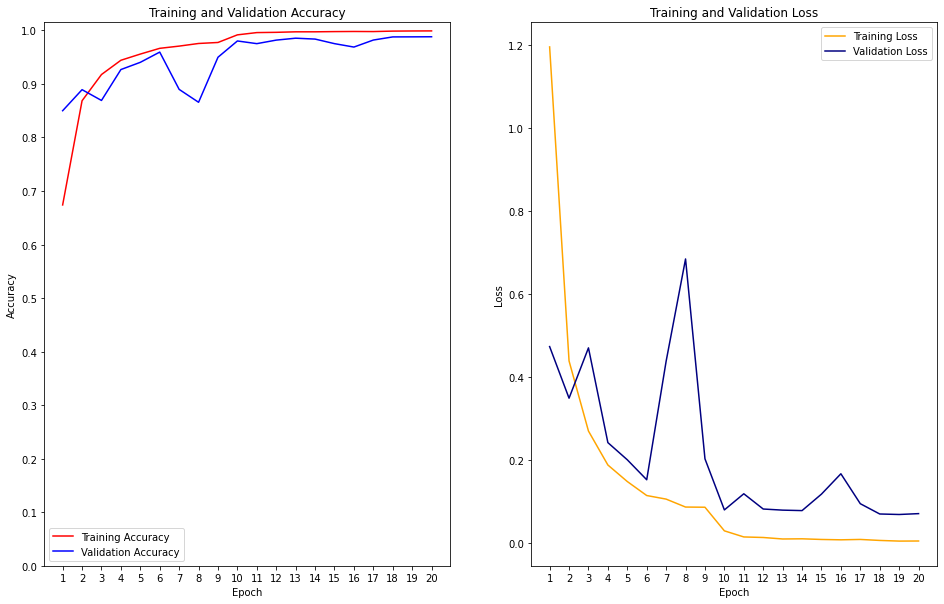

In [14]:
# Plot Accuracy & Loss
plot_acc_and_loss(history)

### 2. Plot Predictions

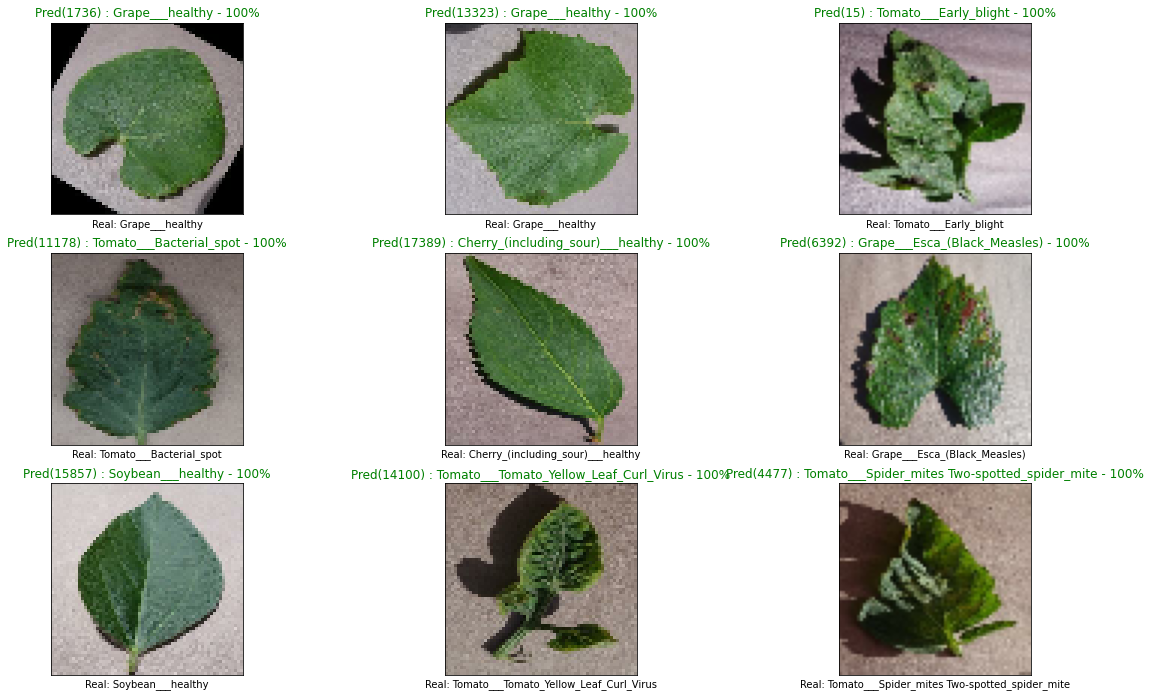

In [15]:
show_img_and_prediction(model)

### 3. Plot wrong predictions

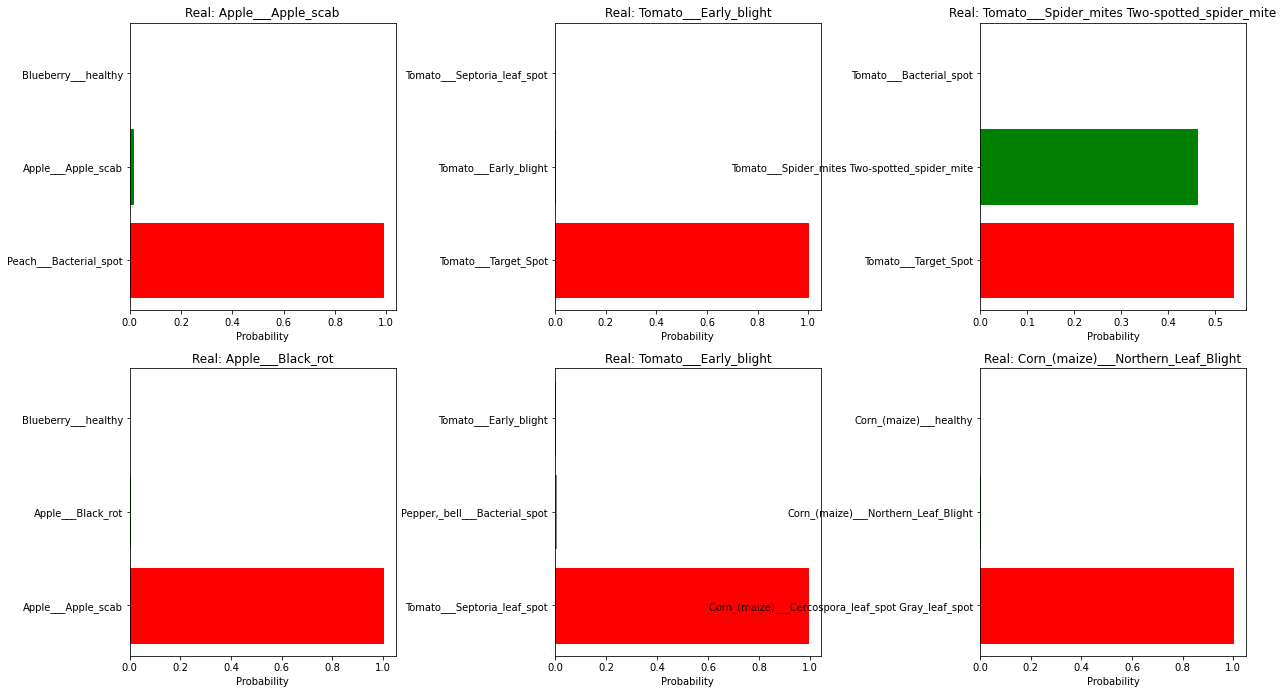

In [16]:
#wrong_pred_idx
wrong_pred_idx = get_wrong_preds(predictions, labels, n=6)

plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace = 0.6)
for i, pred_idx in enumerate(wrong_pred_idx):
    plt.subplot(3,3,i+1)
    plot_pred_prob(predictions, labels, n=pred_idx)
    plt.title('Real: {}'.format(labels[pred_idx]))


## Evaluate model with Test dataset

In [17]:
# Get test data
import os
import pandas as pd


test_path = '../input/new-plant-diseases-dataset/test/test'

test_imgs = [os.path.join(test_path,img) for img in os.listdir(test_path)]
df_test = pd.DataFrame(test_imgs, columns=['Path'])

df_test.head()

,Path
0,../input/new-plant-diseases-dataset/test/test/...
1,../input/new-plant-diseases-dataset/test/test/...
2,../input/new-plant-diseases-dataset/test/test/...
3,../input/new-plant-diseases-dataset/test/test/...
4,../input/new-plant-diseases-dataset/test/test/...


In [18]:
#Create Test Dataset
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

test_dataset = create_dataset(df_test['Path'], test_data=True, img_shape=IMG_SHAPE)

Creating data set...
Creating test data batches...
Image size: ((64, 64))
TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)


Now that we get our predictions from the Test data we can:
- Create a Dataframe with the Test images and the prediciton probabilities for each categories
- Show each Test images with Prediction label and Real label

In [19]:
# Create a DF with Predictions
preds_df = pd.DataFrame(columns=["id"] + list(unique_plant_cat))
# Append test image ID's to prediction DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [20]:
test_preds = model.predict(test_dataset)

In [21]:
# Add the prediction probabilities to each plants category columns
preds_df[list(unique_plant_cat)] = test_preds
preds_df.head()

,id,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Blueberry___healthy,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour)___healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,...,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
0,TomatoEarlyBlight6,2.22038e-06,2.95799e-08,5.22383e-06,0.00116192,6.47884e-09,2.20413e-06,2.29645e-09,3.87828e-08,1.2061e-10,...,0.0984692,0.0232919,0.000611789,1.07444e-05,9.65266e-05,0.0136891,0.849686,0.0124803,6.33881e-07,6.18912e-05
1,TomatoYellowCurlVirus4,1.6795e-31,0,2.6273e-27,6.78e-32,1.40105e-31,4.31441e-27,0,0,0,...,4.50572e-18,9.2784e-20,1.39467e-25,1.28181e-21,1.47493e-23,1.21133e-21,6.22732e-28,1,3.25577e-26,0
2,TomatoYellowCurlVirus6,0,0,0,0,0,0,0,0,0,...,1.47234e-33,0,0,0,0,0,0,1,0,0
3,PotatoHealthy2,3.24741e-15,2.22294e-14,2.2678e-12,1.17511e-09,3.28699e-11,6.12161e-13,4.16578e-08,7.51347e-18,4.77252e-24,...,1.48571e-17,1.18442e-17,1.35201e-12,1.61626e-15,6.43685e-15,1.26025e-14,8.32304e-11,1.54102e-16,1.03676e-16,2.54584e-16
4,TomatoYellowCurlVirus5,1.01392e-31,0,6.77651e-25,4.78731e-34,1.55555e-36,2.97114e-26,0,0,0,...,6.09993e-11,9.32936e-22,3.06029e-23,5.52496e-26,2.52388e-24,1.48314e-27,4.03906e-27,1,5.75436e-31,0


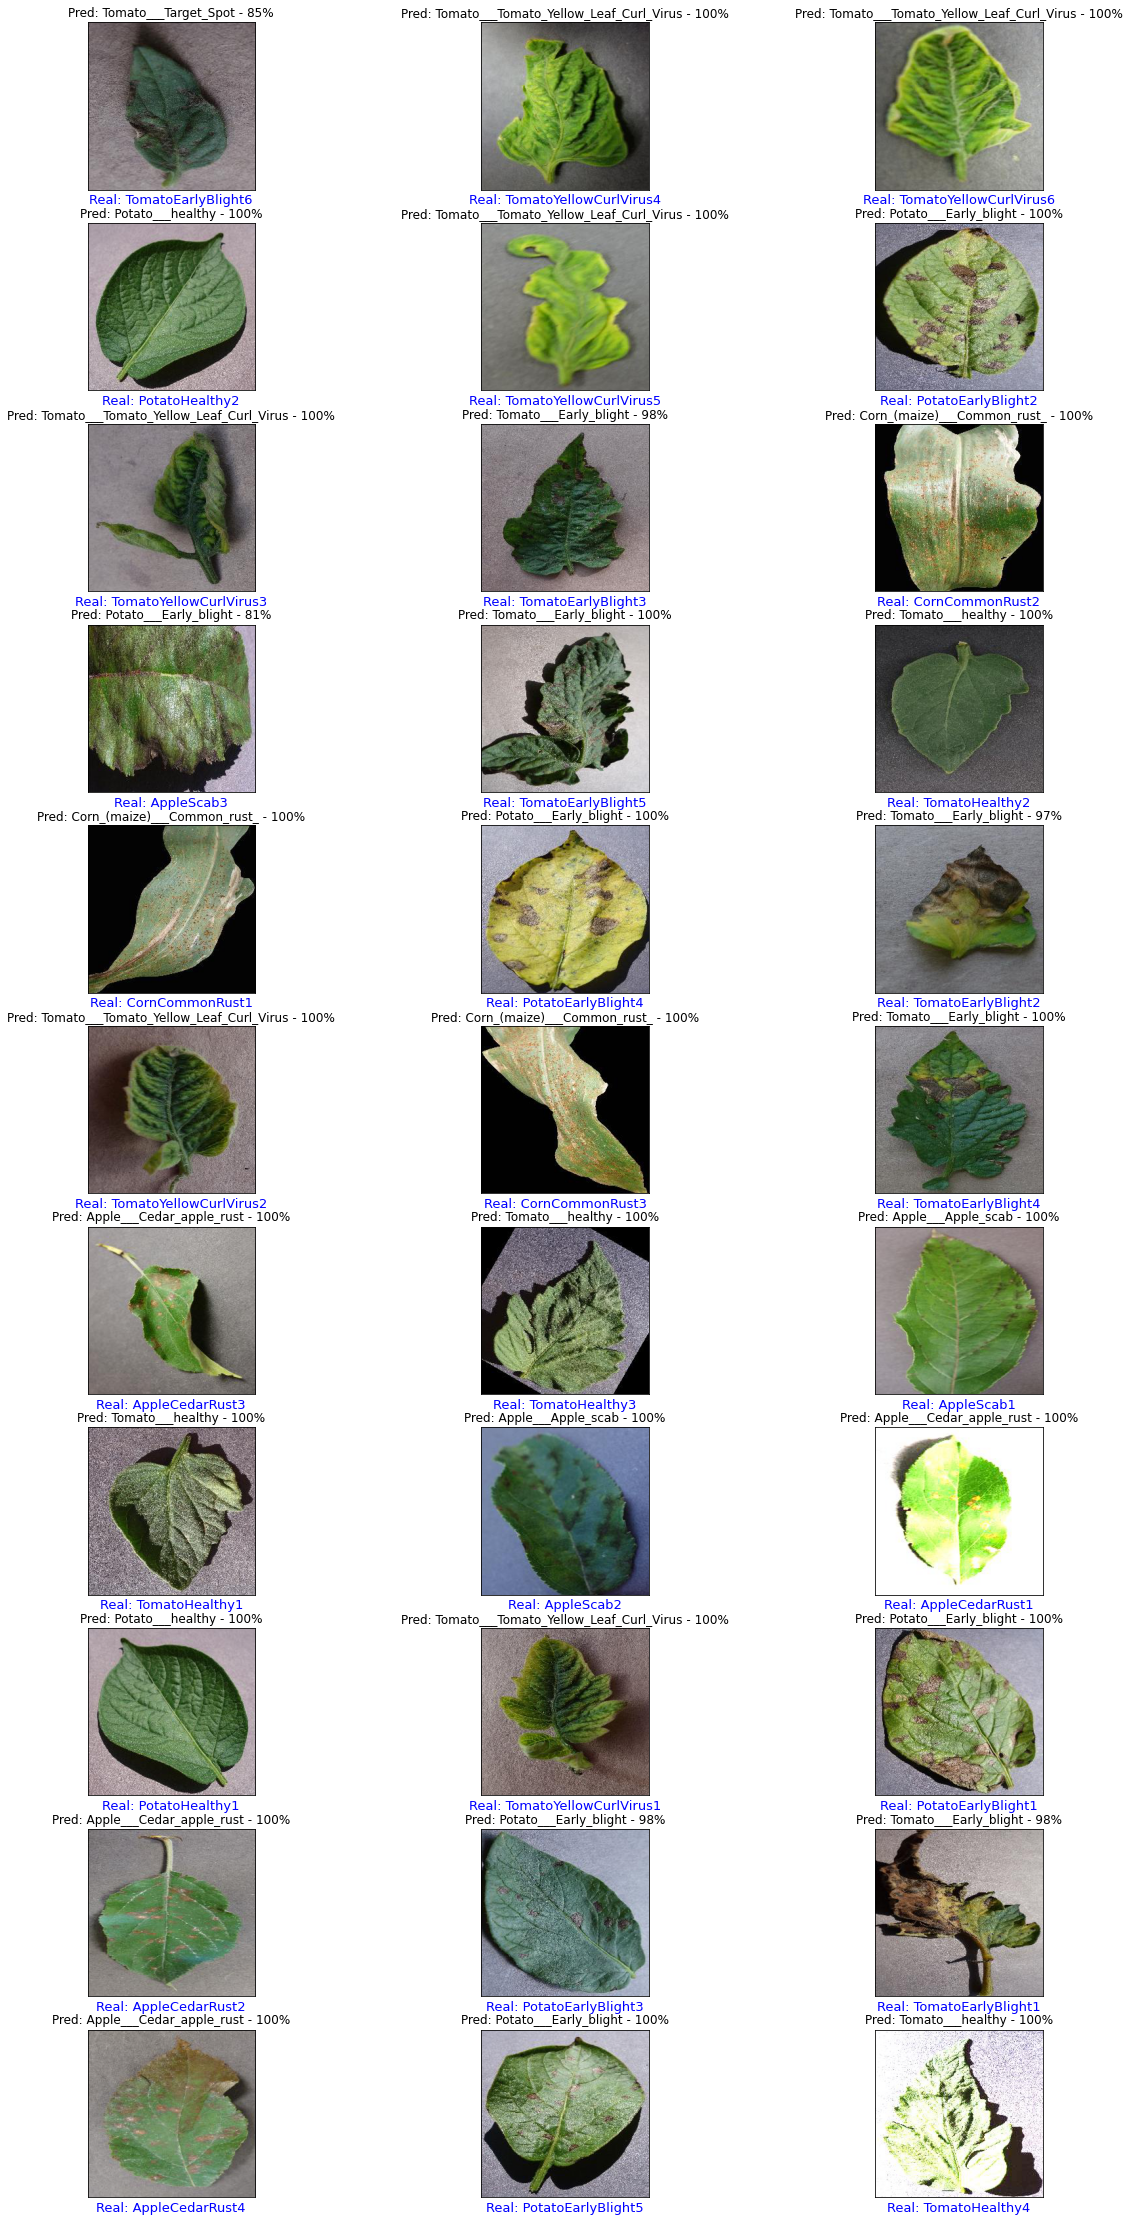

In [22]:
# Show Test Images
import matplotlib.image as mpimg

images_test = []
for img_path in df_test['Path']:
    images_test.append(mpimg.imread(img_path))

plt.figure(figsize=(20,40))
for i, image in enumerate(images_test):
    plt.subplot(11,3,i+1)
    plt.imshow(image)
    plt.title('Pred: {} - {:2.0f}%'.format( get_pred_label(test_preds[i]), np.max(test_preds[i])*100))
    plt.xlabel(f'Real: {test_ids[i]}', fontsize=13, color='blue')
    plt.xticks([])
    plt.yticks([])

## What Next?

We can see that most of the predictions are correct. So our model has been well trained.

Now that we validate our model, we should design a better application where the user can upload a picture of a plant, and the application should provide below information:
- What kind of plant?
- Is the plant healthy or diseased?
- If the plant is diseased, provide information about the disease itself.